## MODULARITY OVER TIME

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import girvan_newman
from collections import defaultdict
import seaborn as sns
from collections import defaultdict, Counter
import json
import community.community_louvain as community_louvain
import re

data=pd.read_json('network_data.json')
list_dates = ["2023-07-01","2023-08-01","2023-09-01","2023-10-06","2023-11-01","2023-12-01","2024-01-01","2024-02-01","2024-03-01","2024-04-01","2024-05-01"]

def filter_data(df,start_date,end_date):

    mask = (data['son_date'] >= start_date) & (data['son_date'] <= end_date) & (data['mother_date'] >= start_date) & (data['mother_date'] <= end_date) & (data.author_son != "AutoModerator") & (data.author_mother != "AutoModerator")

    return df[mask].reset_index(drop = True)

def define_top_authors(df, n):
    list_author_son = df.groupby("author_son")["text_son"].count().reset_index().sort_values("text_son",ascending = False).head(n).author_son.tolist()
    list_author_mother = df.groupby("author_mother")["text_mother"].count().reset_index().sort_values("text_mother",ascending = False).head(n).author_mother.tolist()
    top_authors = set(list_author_son + list_author_mother)

    return top_authors

In [6]:
n_authors = 100
modularities = []
for i in range(len(list_dates)-1):
    filtered_data = filter_data(data,list_dates[i],list_dates[i+1])
    top_authors = define_top_authors(filtered_data,n_authors)
    cleaned_data = filtered_data[filtered_data.author_son.isin(top_authors) & (filtered_data.author_mother.isin(top_authors))].dropna(subset=['author_son', 'author_mother'])

    # GENERATE THE GRAPH FROM THE DATA, WEIGHTING EDGES BY THE TOTAL NUMBER OF INTERACTIONS BETWEEN NODES (users)
    G = nx.Graph()
    for index, row in cleaned_data.iterrows():
        son = row['author_son']
        mother = row['author_mother']
        if G.has_edge(son, mother):
            G[son][mother]['weight'] += 1
        else:
            G.add_edge(son, mother, weight=1)

    # REMOVE ISOLATED COMPONENTS (1 or 2 nodes)
    connected_components = list(nx.connected_components(G))
    isolated_components = [component for component in connected_components if (len(component) == 2) or (len(component) == 1)]
    nodes_to_remove = [node for component in isolated_components for node in component]
    G.remove_nodes_from(nodes_to_remove)

    # GENERATE THE COMMUNITIES
    partition = community_louvain.best_partition(G,weight = 'weight')
    community_dict = defaultdict(list)
    for node, comm in partition.items():
        community_dict[comm].append(node)
    communities = list(community_dict.values())

    # COMPUTE MODULARITY AND STORE IT 
    mod_level = community_louvain.modularity(partition, G, weight='weight')
    modularities.append(mod_level)


In [214]:
list_dates = ["2023-07-01","2023-08-01","2023-09-01","2023-10-06","2023-11-01","2023-12-01","2024-01-01","2024-02-01","2024-03-01","2024-04-01","2024-05-01"]

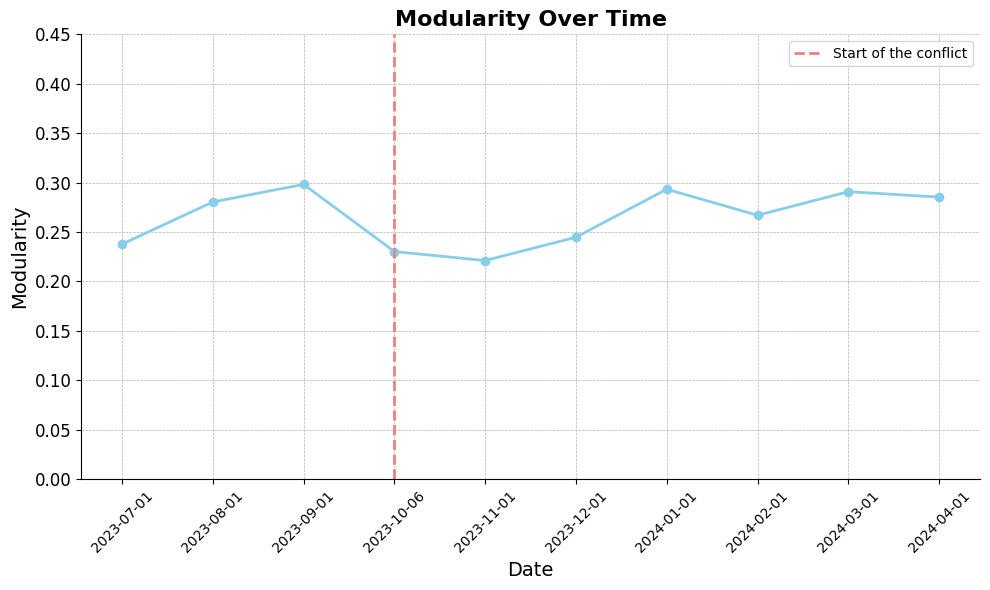

In [217]:

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(list_dates[:10], modularities, marker='o', linestyle='-', color='skyblue', linewidth=2, markersize=6)

# Aesthetics
plt.title('Modularity Over Time', fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Modularity', fontsize=14)
plt.axvline(x="2023-10-06", color='lightcoral', linestyle='--', linewidth=2, label='Start of the conflict')

plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=12)
plt.ylim(0, 0.45)  # Set the y-axis range from 0 to 0.45
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Hide right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.tight_layout()
plt.legend()
plt.savefig("modularity.png")
plt.show()